In [1]:
import sys
sys.path.append("../")

In [2]:
from common.camera import *
from common.visualization import *
from common.utils import *
from common.generators import ChunkedGenerator, UnchunkedGenerator
from common.h36m_dataset import Human36mDataset, preprocess_Human36m
from common.visualization import *
from common.xianhui_dataset import *
import matplotlib
import glob
import plotly
import json
%matplotlib inline
plotly.offline.init_notebook_mode(connected=True)

wild data

- 0 hips Pelvis
- 1 right_upper_leg RHip
- 2 right_lower_leg RKnee
- 3 right_foot RAnkle
- 4 left_upper_leg LHip
- 5 left_lower_leg LKnee
- 6 left_foot LAnkle
- 7 chest Spine1
- 8 neck Neck
- 9 head Head
- 10 head Site
- 11 left_upper_arm LShoulder
- 12 left_lower_arm LElbow
- 13 left_hand LWrist
- 14 right_upper_arm RShoulder
- 15 right_lower_arm RElbow
- 16 right_hand RWrist

In [3]:
# for i, k in enumerate(sorted(list(data["1"].keys()))):
#     print(i, k)

In [4]:
cam_0_data_path = "../../wild_data/2019.05.30_14.03/1.json"
cam_0_img_paths = ["../../wild_data/2019.05.30_14.03/BonesInfo_Camera_1/{}.png".format(str(i+1)) for i in range(49)]
cam_0_img_cal_paths = glob.glob('../../wild_data/2019.05.30_14.03/Camera_0/*.png')
pts_3d, cam_0_pts_2d, cam_0_params, cam_0_imgs = xianhui_data_processing(cam_0_data_path, cam_0_img_paths, cam_0_img_cal_paths, cam_id = "cam_0", chess_board_shape = (7, 5))

cam_1_data_path = "../../wild_data/2019.05.30_14.03/2.json"
cam_1_img_paths = ["../../wild_data/2019.05.30_14.03/BonesInfo_Camera_2/{}.png".format(str(i+1)) for i in range(49)]
cam_1_img_cal_paths = glob.glob('../../wild_data/2019.05.30_14.03/Camera_1/*.png')
pts_3d, cam_1_pts_2d, cam_1_params, cam_1_imgs = xianhui_data_processing(cam_1_data_path, cam_1_img_paths, cam_1_img_cal_paths, cam_id = "cam_1", chess_board_shape = (7, 5))

calibrate camera
load 3d and 2d skeletons
estimate extrinsics
calibrate camera
load 3d and 2d skeletons
estimate extrinsics


In [5]:
cameras = {}
cameras["S1"] = [cam_0_params, cam_1_params]
data = {}
data["S1"] = {}
data["S1"]["somba"] = {
    "positions" : pts_3d,
    "cameras" : cameras["S1"]
}

dataset = XianhuiDataset(cameras, data)

In [6]:
human36m_kpts_name = ['Pelvis', 'RHip', 'RKnee', 'RAnkle','LHip','LKnee',
                      'LAnkle','Spine1','Neck', 'Head','Site','LShoulder',
                      'LElbow','LWrist','RShoulder', 'RElbow','RWrist']

original data 3D

In [7]:
# sample 3d position
viz_subject = "S1"                                              # subject 1
viz_action = "somba"                                        # action
cam_0 = dataset.cameras()[viz_subject][0]                       # get cam_0 info
cam_1 = dataset.cameras()[viz_subject][1]                       # get cam_1 info
pos_world = dataset._data[viz_subject][viz_action]['positions'].copy() # sample a sequences of skeletons
print("# frames : {} -- # keypoints : {} -- world coordinates {}".format(pos_world.shape[0], pos_world.shape[1], pos_world.shape[2]))

# frames : 269 -- # keypoints : 17 -- world coordinates 3


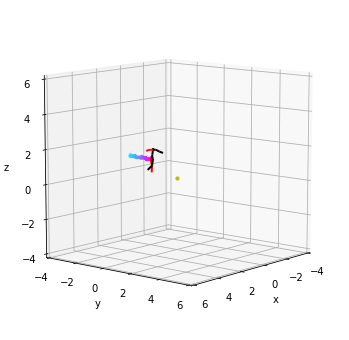

In [8]:
m = 100
fig = plt.figure(figsize=(6,6))
ax_3d_w = fig.add_subplot(1,1,1,projection='3d')
ax_3d_w = display_3D_skeleton_beta(ax_3d_w, pos_world[m], dataset.skeleton())
ax_3d_w = display_trajectory(ax_3d_w, pos_world, m)
ax_3d_w.view_init(elev=10, azim=40)
ax_3d_w.dist = 10

In [9]:
pos_world.shape

(269, 17, 3)

In [10]:
# frames, layout = generate_frames_layout(pos_world[::20], dataset.skeleton(), human36m_kpts_name)
# fig = dict(data=get_line_3d_segs(pos_world[::20], 0, dataset.skeleton(), human36m_kpts_name), layout=layout, frames=frames)
# plotly.offline.iplot(fig)

preprocessing 3D

- convert 3d pts from world coord to camera coord

In [11]:
for subject in dataset.subjects():
    for action in dataset[subject].keys():
        anim = dataset[subject][action]        
        positions_3d = []
        for cam in anim['cameras']:
            nframe = anim['positions'].shape[0]
            pts_3d_homo = np.ones((nframe, 17, 4))
            pts_3d_homo[... , :3] = anim['positions']
            pts_3d_homo = pts_3d_homo.reshape(-1, 4).T

            pts_3d_cam = world2camera_cv(pts_3d_homo, cam_0_params['rvec'], cam_0_params['tvec'])[:3]
            pos_camera = pts_3d_cam.T.reshape(nframe, 17, 3)

            positions_3d.append(pos_camera)
            
        anim['positions_3d'] = positions_3d

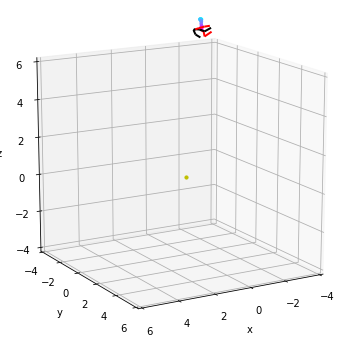

In [12]:
pos_camera = dataset[viz_subject][viz_action]['positions_3d'][1].copy()
m = 40
fig = plt.figure(figsize=(6,6))
ax_3d_c = fig.add_subplot(1,1,1,projection='3d')
ax_3d_c = display_3D_skeleton_beta(ax_3d_c, pos_camera[m], dataset.skeleton())
ax_3d_c = display_trajectory(ax_3d_c, pos_camera, m)

In [13]:
obj_pts = pos_camera.reshape(-1, 3)

In [14]:
frames, layout = generate_frames_layout(pos_camera[::10], 
                                        dataset.skeleton(), 
                                        human36m_kpts_name, 
                                        x_range = [-2, 5], 
                                        y_range = [-3, 2], 
                                        z_range = [-10, -4])

fig = dict(data=get_line_3d_segs(pos_camera, 0, dataset.skeleton(), human36m_kpts_name), 
           layout=layout, frames=frames)
plotly.offline.iplot(fig)

preprocessing 3D

- remove global offset but keep trajectory in first position

In [15]:
for subject in dataset.subjects():
    for action in dataset[subject].keys():
        anim = dataset[subject][action]        
        positions_3d = []
        for cam in anim['cameras']:
            nframe = anim['positions'].shape[0]
            pts_3d_homo = np.ones((nframe, 17, 4))
            pts_3d_homo[... , :3] = pos_world
            pts_3d_homo = pts_3d_homo.reshape(-1, 4).T

            pts_3d_cam = world2camera_cv(pts_3d_homo, cam_0_params['rvec'], cam_0_params['tvec'])[:3]
            pos_camera = pts_3d_cam.T.reshape(nframe, 17, 3)
            pos_camera[:, 1:] -= pos_camera[:, :1]

            positions_3d.append(pos_camera)
            
        anim['positions_3d'] = positions_3d

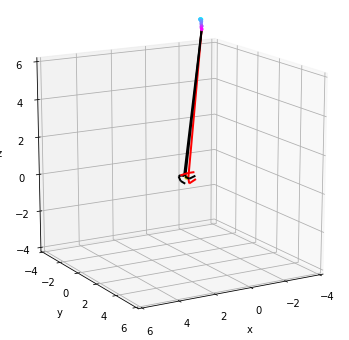

In [16]:
pos_camera = dataset[viz_subject][viz_action]['positions_3d'][1].copy()
m = 40
fig = plt.figure(figsize=(6,6))
ax_3d_c_remove_offset = fig.add_subplot(1,1,1,projection='3d')
ax_3d_c_remove_offset = display_3D_skeleton_beta(ax_3d_c_remove_offset, pos_camera[m], dataset.skeleton())
ax_3d_c_remove_offset = display_trajectory(ax_3d_c_remove_offset, pos_camera, m)

In [17]:
frames, layout = generate_frames_layout(pos_camera[::10], 
                                        dataset.skeleton(), 
                                        human36m_kpts_name, 
                                        x_range = [-2, 5], 
                                        y_range = [-3, 2], 
                                        z_range = [-10, 4])
fig = dict(data=get_line_3d_segs(pos_camera, 0, dataset.skeleton(), human36m_kpts_name), layout=layout, frames=frames)
plotly.offline.iplot(fig)

original data 2D

In [18]:
# keypoints index
kpts_name = ['Pelvis', 'RHip', 'RKnee', 
             'RAnkle','LHip','LKnee',
             'LAnkle','Spine1','Neck',
             'Head','Site','LShoulder',
             'LElbow','LWrist','RShoulder',
             'RElbow','RWrist']

In [19]:
joints_left, joints_right = list(dataset.skeleton().joints_left()), list(dataset.skeleton().joints_right())
kps_left = joints_left
kps_right = joints_right

In [20]:
keypoints = {}
keypoints["S1"] = {}
keypoints["S1"]["somba"] = [cam_0_pts_2d, cam_1_pts_2d]

In [21]:
print("kps_left : ", [kpts_name[i] for i in kps_left])
print("kps_right : ", [kpts_name[i] for i in kps_right])
print("joints_left : ", [kpts_name[i] for i in joints_left])
print("joints__right : ", [kpts_name[i] for i in joints_right])
# print("keypoints_symmetry : ", [(kpts_name[x], kpts_name[y]) for x, y in zip(keypoints_symmetry[0], keypoints_symmetry[1])])

kps_left :  ['LHip', 'LKnee', 'LAnkle', 'LShoulder', 'LElbow', 'LWrist']
kps_right :  ['RHip', 'RKnee', 'RAnkle', 'RShoulder', 'RElbow', 'RWrist']
joints_left :  ['LHip', 'LKnee', 'LAnkle', 'LShoulder', 'LElbow', 'LWrist']
joints__right :  ['RHip', 'RKnee', 'RAnkle', 'RShoulder', 'RElbow', 'RWrist']


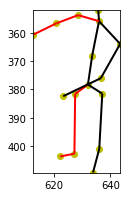

In [22]:
keypoints_2d_cam_1 = keypoints[viz_subject][viz_action][1].copy()
fig = plt.figure(figsize=(3,3))
ax_2d_cam_1_origin = fig.add_subplot(1,1,1, aspect='equal')
ax_2d_cam_1_origin = display_2D_skeleton_beta(ax_2d_cam_1_origin, keypoints_2d_cam_1[m], dataset.skeleton())

preprocessing 2D

- remove extra frames

In [23]:
num_data = 0
num_shorten = 0
for subject in dataset.subjects():
    for action in dataset[subject].keys():
        for cam_idx in range(len(keypoints[subject][action])):
            mocap_length = dataset[subject][action]['positions_3d'][cam_idx].shape[0]
            kpts_length = keypoints[subject][action][cam_idx].shape[0]
            
            num_data += 1
                
            if keypoints[subject][action][cam_idx].shape[0] > mocap_length:
                # Shorten sequence
                keypoints[subject][action][cam_idx] = keypoints[subject][action][cam_idx][:mocap_length]
                num_shorten += 1
print(" shorten {}|{}".format(num_shorten, num_data))

 shorten 0|2


preprocessing 2D

- Normalize Images so that [0, w] is mapped to [-1, 1], while preserving the aspect ratio

In [24]:
for subject in keypoints.keys():
    for action in keypoints[subject]:
        for cam_idx, kps in enumerate(keypoints[subject][action]):
            # Normalize camera frame
            cam = dataset.cameras()[subject][cam_idx]
            kps[..., :2] = normalize_screen_coordinates(kps[..., :2], w=cam['res_w'], h=cam['res_h'])
            keypoints[subject][action][cam_idx] = kps

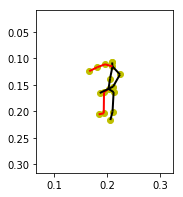

In [25]:
keypoints_2d_cam_1_norm = keypoints[viz_subject][viz_action][1].copy()
fig = plt.figure(figsize=(3,3))
ax_2d_cam_1_origin = fig.add_subplot(1,1,1, aspect='equal')
ax_2d_cam_1_origin = display_2D_skeleton_beta(ax_2d_cam_1_origin, keypoints_2d_cam_1_norm[m], dataset.skeleton())

define subsets

In [26]:
subjects_train = ['S1']
subjects_semi = ['S1']
subjects_test = ['S1']

In [27]:
cameras_valid, poses_valid, poses_valid_2d = fetch(dataset = dataset, 
                                                   keypoints = keypoints, 
                                                   subjects = subjects_test, 
                                                   stride = 1)
cameras_train, poses_train, poses_train_2d = fetch(dataset = dataset, 
                                                   keypoints = keypoints, 
                                                   subjects = subjects_train, 
                                                   stride = 1)
cameras_semi, _, poses_semi_2d = fetch(dataset = dataset,
                                       keypoints = keypoints,
                                       subjects = subjects_train, 
                                       stride = 1, 
                                       parse_3d_poses = False)

_, poses_valid_s5, poses_valid_2d_s5 = fetch(dataset = dataset,
                                             keypoints = keypoints,
                                             subjects = subjects_test,
                                             stride = 1)
print(poses_valid_2d_s5[0].shape, poses_valid_2d[0].shape)

(269, 17, 2) (269, 17, 2)


data generator

In [28]:
train_generator = ChunkedGenerator(batch_size=20, 
                                   cameras = cameras_train, 
                                   poses_3d = poses_train,
                                   poses_2d = poses_train_2d, 
                                   chunk_length = 1,
                                   pad = 13, # setted by receptive field
                                   causal_shift = 0, 
                                   shuffle = True, 
                                   augment = False,
                                   kps_left = kps_left, 
                                   kps_right = kps_right, 
                                   joints_left = joints_left, 
                                   joints_right = joints_right)

In [29]:
for a, batch_3d, batch_2d in train_generator.next_epoch():
    break
    print(train_generator.pairs)

In [30]:
batch_2d.shape


(20, 27, 17, 2)

In [31]:
batch_3d.shape

(20, 1, 17, 3)

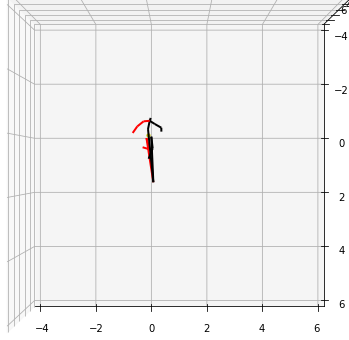

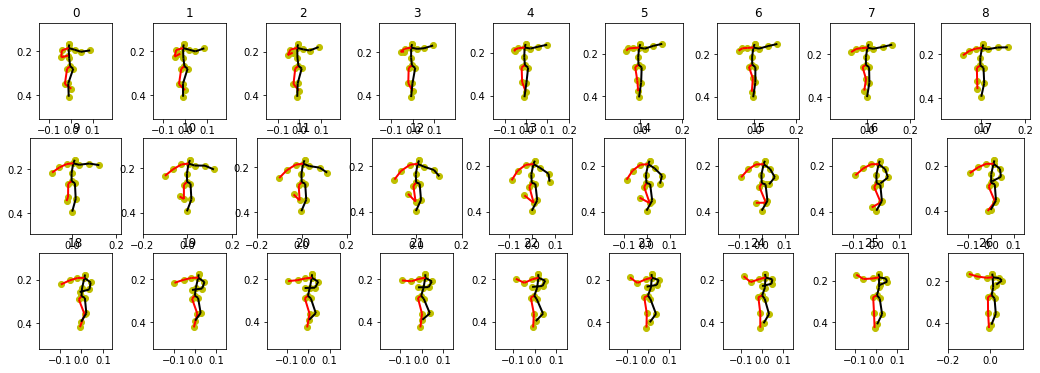

In [33]:
n = 5
fig = plt.figure(figsize=(6,6))
ax_3d = fig.add_subplot(1,1,1,projection='3d')
ax_3d = display_3D_skeleton_beta(ax_3d, batch_3d[n][0], dataset.skeleton())
ax_3d.view_init(elev=-90., azim=-90.)
ax_3d.dist = 6
fig = plt.figure(figsize=(18,6))
for i in range(9):
    for j in range(3):
        ax_2d = fig.add_subplot(3,9,i*3+j+1, aspect='equal')
        ax_2d = display_2D_skeleton_beta(ax_2d, batch_2d[n][i*3+j], dataset.skeleton())
        ax_2d.set_title(str(i*3+j))